In [1]:
import itertools
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import plot_roc_curve, roc_auc_score

pd.set_option('display.max_columns', 999)
random_state=0


In [2]:
project_path = 'C:\\Users\\a\\PycharmProjects\\interview'
data_path = os.path.join(project_path, 'data', 'bank-additional-full.csv')
print(data_path)


C:\Users\a\PycharmProjects\interview\data\bank-additional-full.csv


In [3]:
df = pd.read_csv(data_path, sep=';', na_values=["unknown"])
df.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
df.shape

(41188, 21)

# Drop duplicate records

In [5]:
df = df.drop_duplicates(ignore_index=True)
df.shape


(41176, 21)

# Drop the duration column as mentioned in dataset

In [6]:
df = df.drop("duration", axis=1)
df.shape


(41176, 20)

# Drop correlated features 

In [7]:
df = df.drop(['euribor3m','nr.employed'],axis=1)

In [8]:
corr = df.corr()
corr.style.background_gradient()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx
age,1.000000,0.004622,-0.034381,0.024379,-0.000242,0.001009,0.129075
campaign,0.004622,1.000000,0.052606,-0.079182,0.150786,0.127826,-0.013657
pdays,-0.034381,0.052606,1.000000,-0.587508,0.271063,0.078920,-0.091374
previous,0.024379,-0.079182,-0.587508,1.000000,-0.420587,-0.203197,-0.050929
emp.var.rate,-0.000242,0.150786,0.271063,-0.420587,1.000000,0.775293,0.196257
cons.price.idx,0.001009,0.127826,0.078920,-0.203197,0.775293,1.000000,0.059170
cons.conf.idx,0.129075,-0.013657,-0.091374,-0.050929,0.196257,0.059170,1.000000


# Split Data into Features and Labels

In [9]:
data = df.drop('y', axis=1)
label = df['y']

# Train Test Split

In [10]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=random_state)
(train_indices, test_indices), (_, _) = sss.split(data, label)
X_train, y_train = data.iloc[data.index[train_indices]].reset_index(drop=True), label[train_indices]
X_test, y_test = data.iloc[data.index[test_indices]].reset_index(drop=True), label[test_indices]


In [11]:
print(f'training data  size {X_train.shape}')
print(f'testing data  size {X_test.shape}')


training data  size (37058, 17)
testing data  size (4118, 17)


In [12]:
class_weight = pd.DataFrame({'y': y_train})['y'].value_counts(normalize=True).to_dict()
print("classes distribution")
print(f"\ttraining: {class_weight}")
print(f"\ttesting: {pd.DataFrame({'y': y_test})['y'].value_counts(normalize=True).to_dict()}")


classes distribution
	training: {'no': 0.8873387662582978, 'yes': 0.1126612337417022}
	testing: {'no': 0.8873239436619719, 'yes': 0.11267605633802817}


In [13]:
X_train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx
0,24,admin.,single,professional.course,no,yes,yes,telephone,jun,mon,1,999,0,nonexistent,1.4,94.465,-41.8
1,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,1,999,0,nonexistent,1.4,93.918,-42.7
2,36,admin.,married,university.degree,no,yes,no,cellular,aug,thu,5,999,0,nonexistent,1.4,93.444,-36.1
3,57,services,divorced,high.school,NaN,no,no,cellular,aug,wed,1,999,0,nonexistent,1.4,93.444,-36.1
4,39,blue-collar,married,high.school,no,yes,no,cellular,jul,mon,4,999,0,nonexistent,1.4,93.918,-42.7


# Data processing

### Replacing Outlier

In [14]:
pdays_mapping = {999: 0}
X_train['pdays'] = X_train['pdays'].replace(pdays_mapping)
X_test['pdays'] = X_test['pdays'].replace(pdays_mapping)



### Scaling the Data

In [15]:
scaler = StandardScaler()

columns_to_scale = ['age', 'campaign', 'previous','pdays','emp.var.rate', 'cons.price.idx', 'cons.conf.idx']

X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

### Caterorical Features

###### Imputing NA by Most repeating category

In [16]:
most_repeating_value =  data.mode().to_dict()

col_with_missing_values = data.columns[data.isnull().sum()>0]

for col in col_with_missing_values:
    X_train[col] = X_train[col].fillna(most_repeating_value[col][0])
    X_test[col] = X_test[col].fillna(most_repeating_value[col][0])

print(f"missing values after imputation in train: {X_train.isnull().sum().sum()}")
print(f"missing values after imputation in test: {X_test.isnull().sum().sum()}")

missing values after imputation in train: 0
missing values after imputation in test: 0


###### Ordinal Encoding

In [17]:
ordinal_mapping_dict = {
    "education": {"unknown": 0, "illiterate": 1, "basic.4y": 2, "basic.6y": 3, "basic.9y": 4, "high.school": 5,
                  "professional.course": 6, "university.degree": 7},
    "contact": {"cellular": 0, "telephone": 1, },
    "default": {"no": 0, "yes": 1},
    "housing": {"no": 0, "yes": 1},
    "loan": {"no": 0, "yes": 1},
}


In [18]:
for col, values in ordinal_mapping_dict.items():
    X_train[col] = X_train[col].replace(values).astype(int)
    X_test[col] = X_test[col].replace(values).astype(int)

###### Onehot Encoding

In [19]:
cat_col = X_train.dtypes[X_train.dtypes=='object'].index

one_hot_encoder=OneHotEncoder()
X_train_transformed = one_hot_encoder.fit_transform(X_train[cat_col])
column_names = list(itertools.chain(*[[f'{col}_{i}' for i in cat] for col, cat in zip(cat_col, one_hot_encoder.categories_)]))


X_train = pd.concat([X_train, pd.DataFrame(X_train_transformed.toarray(), columns=column_names)], axis=1)
X_test = pd.concat([X_test, pd.DataFrame(one_hot_encoder.transform(X_test[cat_col]).toarray(), columns=column_names)], axis=1)

X_train = X_train.drop(cat_col, axis=1)
X_test = X_test.drop(cat_col, axis=1)


### Label Encoding

In [20]:
label_enc = LabelEncoder()
y_train = label_enc.fit_transform(y_train)
y_test = label_enc.transform(y_test)


# Cross Valdiation Set Generator

In [21]:
cv_generator = StratifiedShuffleSplit(n_splits=5, test_size=0.01, random_state=random_state)

# Plot the Area Under ROC Curve

In [22]:
def plot_metrics(classifier, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    fig = plt.figure(figsize=(10, 5)).gca()
    plot_roc_curve(classifier, X_train, y_train, ax=fig, name='train')
    plot_roc_curve(classifier, X_test, y_test, ax=fig, name='test')
    plt.show()

# Logistic Regresstion

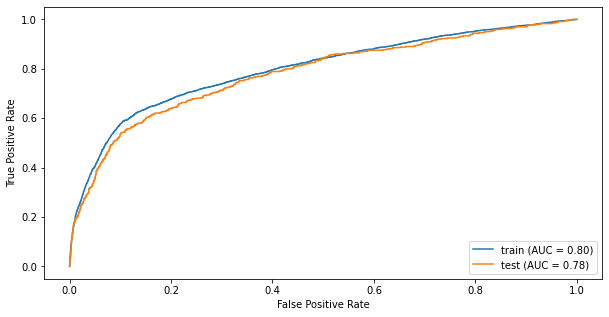

In [23]:
lr = LogisticRegression(class_weight ='balanced', max_iter=1000,random_state=random_state)

lr.fit(X_train,y_train)

plot_metrics(lr)
# plt.title(f'logistic regression')
# plt.savefig("logistic regresstion.jpg", bbox_inches='tight', dpi=150)


### Cross Validation - LR

In [24]:
lr_cv = LogisticRegression(class_weight ='balanced', max_iter=1000, random_state=random_state)

cv_generator = StratifiedShuffleSplit(n_splits=3, test_size=0.01,random_state=random_state)

cv = cross_validate(lr_cv, X_train, y_train, 
                    cv=cv_generator, 
                    scoring={'roc_auc':'roc_auc'},
                    return_train_score=True,
                    return_estimator=True)

print("roc_auc")
print(f"\ttrain: {np.mean(cv['train_roc_auc'])}")
print(f"\tval: {np.mean(cv['test_roc_auc'])}")
print(f"\ttest: {np.mean([roc_auc_score(y_test, es.predict_proba(X_test)[:,1]) for es in cv['estimator']])}")


roc_auc
	train: 0.7972304331054886
	val: 0.780250398031553
	test: 0.7803716718884676


### Grid Search - LR

Best params: {'C': 0.3, 'l1_ratio': 0}


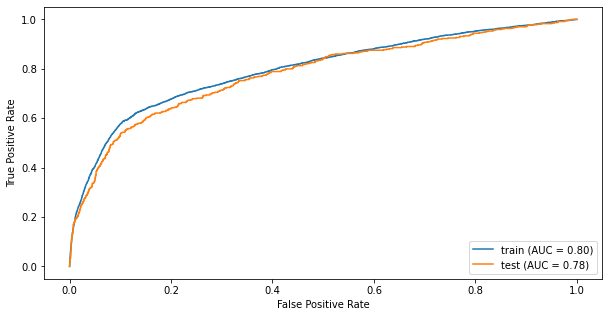

In [25]:
param_grid = {
    'C': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'l1_ratio': [0, 0.5, 0.7, 1]
}

lr_cv = LogisticRegression(class_weight ='balanced', 
                           max_iter=1000, 
                           penalty='elasticnet', 
                           solver='saga',
                           random_state=random_state)

lr_search = GridSearchCV(lr_cv, 
                      param_grid, 
                      cv=cv_generator,
                      scoring='f1')

lr_search.fit(X_train, y_train)

print(f"Best params: {lr_search.best_params_}")
plot_metrics(lr_search)


# Random Forest

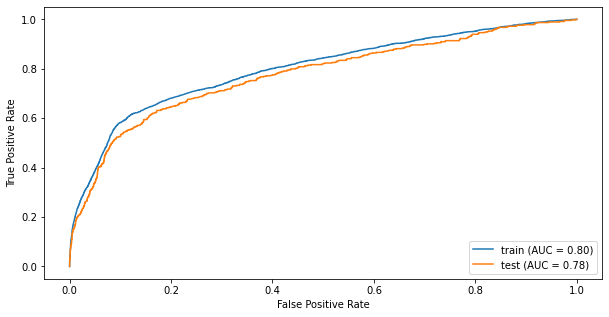

In [26]:
rfc = RandomForestClassifier(class_weight ='balanced_subsample',
                            max_depth=5,
                            random_state=random_state)

rfc.fit(X_train,y_train)

plot_metrics(rfc)


<BarContainer object of 44 artists>

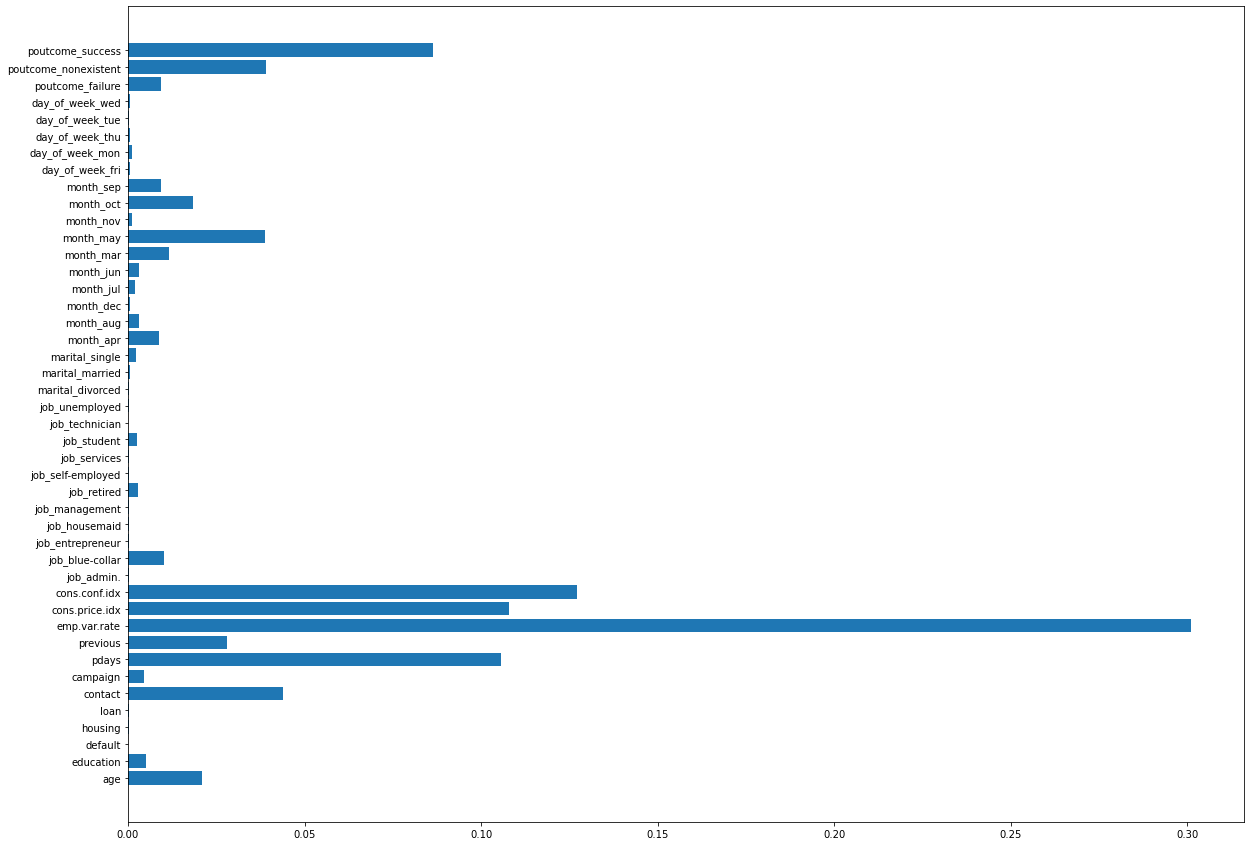

In [27]:
plt.figure(figsize=(20,15))
plt.barh(X_train.columns, rfc.feature_importances_)